In [1]:
from google.colab import files

# This will open a "Choose Files" dialog in your browser
print("Please select your water_dataset.zip file for upload...")
uploaded = files.upload()

# Print a confirmation message once it's done
for fn in uploaded.keys():
  print(f'Successfully uploaded file "{fn}"')

Please select your water_dataset.zip file for upload...


Saving water_images.zip to water_images.zip
Successfully uploaded file "water_images.zip"


In [2]:
# Make sure the filename matches what you uploaded
!unzip -q water_images.zip

In [3]:
# 'ls' is a command to "list" files and directories
# -R means "recursive" (show me all folders inside)
!ls -R water_images

water_images:
test  train

water_images/test:
algae_bloom  healthy_water

water_images/test/algae_bloom:
10.jpg	12.jpg	14.jpg	1.jpg  3.jpg  5.jpg  7.jpg  9.jpg
11.jpg	13.jpg	15.jpg	2.jpg  4.jpg  6.jpg  8.jpg

water_images/test/healthy_water:
10.jpg	12.jpg	14.jpg	1.jpg  3.jpg  5.jpg  7.jpg  9.jpg
11.jpg	13.jpg	15.jpg	2.jpg  4.jpg  6.jpg  8.jpg

water_images/train:
algae_bloom  healthy_water

water_images/train/algae_bloom:
51.jpg	63.jpg	75.jpg	     image15.jpg  image26.jpg  image37.jpg  image48.jpg
52.jpg	64.jpg	76.jpg	     image16.jpg  image27.jpg  image38.jpg  image49.jpg
53.jpg	65.jpg	77.jpg	     image17.jpg  image28.jpg  image39.jpg  image4.jpg
54.jpg	66.jpg	78.jpg	     image18.jpg  image29.jpg  image3.jpg   image50.jpg
55.jpg	67.jpg	79.jpg	     image19.jpg  image2.jpg   image40.jpg  image5.jpg
56.jpg	68.jpg	80.jpg	     image1.jpg   image30.jpg  image41.jpg  image6.jpg
57.jpg	69.jpg	iamge14.jpg  image20.jpg  image31.jpg  image42.jpg  image7.jpg
58.jpg	70.jpg	iimage6.jpg  image21.jpg

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Our Project's "Settings" ---

# Define the size to resize all images to
IMG_SIZE = (150, 150)
BATCH_SIZE = 16  # How many images to process at a time

# Define the paths based on your unzipped folder name
TRAIN_DIR = 'water_images/train'
TEST_DIR = 'water_images/test'

In [5]:
# 1. Create augmentation generator
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Create test generator
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 3. Create the actual "generators"
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 157 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [6]:
model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully.")


Model compiled successfully.


In [8]:
print("Starting model training...")

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

print("Model training complete.")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5912 - loss: 0.7266 - val_accuracy: 0.8333 - val_loss: 0.2933
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9315 - loss: 0.2763 - val_accuracy: 0.9667 - val_loss: 0.0682
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 998ms/step - accuracy: 0.9363 - loss: 0.1559 - val_accuracy: 0.9333 - val_loss: 0.1691
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 844ms/step - accuracy: 0.9750 - loss: 0.0938 - val_accuracy: 0.9667 - val_loss: 0.0567
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 882ms/step - accuracy: 0.9102 - loss: 0.1716 - val_accuracy: 0.9667 - val_loss: 0.0634
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9555 - loss: 0.0881 - val_accuracy: 0.9000 - val_loss: 0.2124
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 986ms/step - accuracy: 0.9643 - loss: 0.1304 - val_accuracy: 0.7333 - val_loss: 0.9794
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step - accuracy: 0.9627 - loss: 0.1461 - val_accuracy: 1.000

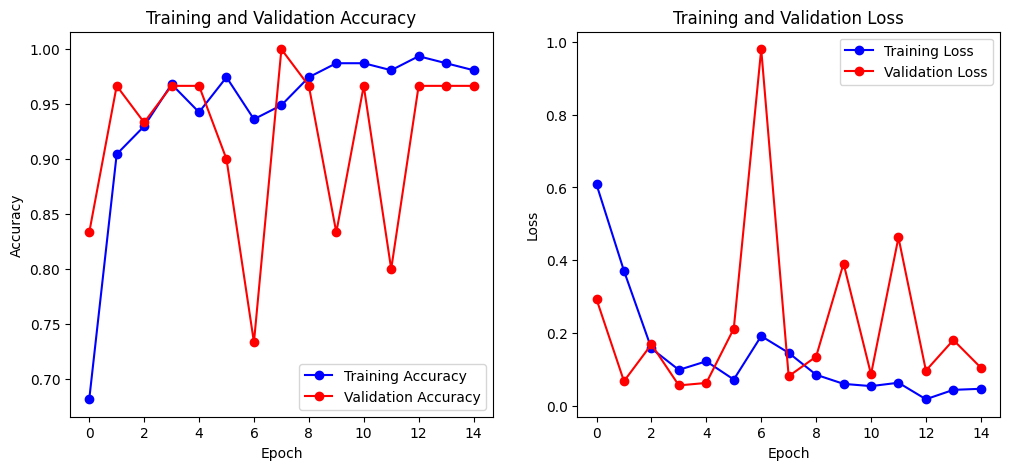

In [9]:
import matplotlib.pyplot as plt

# --- Get the data from our 'history' object ---
# This object was created when you ran model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# --- Plot Training & Validation Accuracy ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st plot)

plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)

plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# --- Build the OPTIMIZED CNN Model ---
model_optimized = keras.Sequential([

    layers.Input(shape=IMG_SIZE + (3,)),

    # --- Block 1 ---
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # --- Block 2 ---
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # <-- NEW: Dropout layer to prevent overfitting

    # --- Block 3 ---
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # <-- NEW: Dropout layer

    # --- The "Classifier" Head ---
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # <-- NEW: More dropout before the final layer

    layers.Dense(1, activation='sigmoid')
])

# Let's see the new architecture
print(model_optimized.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# --- Compile the new model ---
model_optimized.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Optimized model compiled successfully.")

Optimized model compiled successfully.


In [12]:
print("Starting optimized model training...")

# --- Train the new model ---
history_optimized = model_optimized.fit(
    train_generator,
    epochs=25,  # Running for a few more epochs
    validation_data=validation_generator
)

print("Optimized model training complete.")

Starting optimized model training...
Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4785 - loss: 1.0900 - val_accuracy: 0.7667 - val_loss: 0.5616
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8501 - loss: 0.4136 - val_accuracy: 0.9667 - val_loss: 0.1753
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 855ms/step - accuracy: 0.9262 - loss: 0.1513 - val_accuracy: 0.8667 - val_loss: 0.2161
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 948ms/step - accuracy: 0.9385 - loss: 0.1508 - val_accuracy: 0.9000 - val_loss: 0.1859
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9535 - loss: 0.0983 - val_accuracy: 0.8333 - val_loss: 0.2566
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 954ms/step - accuracy: 0.9959 - loss: 0.0422 - val_accuracy: 0.8333 - val_loss: 0.3534
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 840ms/step - accuracy: 0.9735 - loss: 0.0679 - val_accuracy: 0.9667 - val_loss: 0.1321
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9836 - 

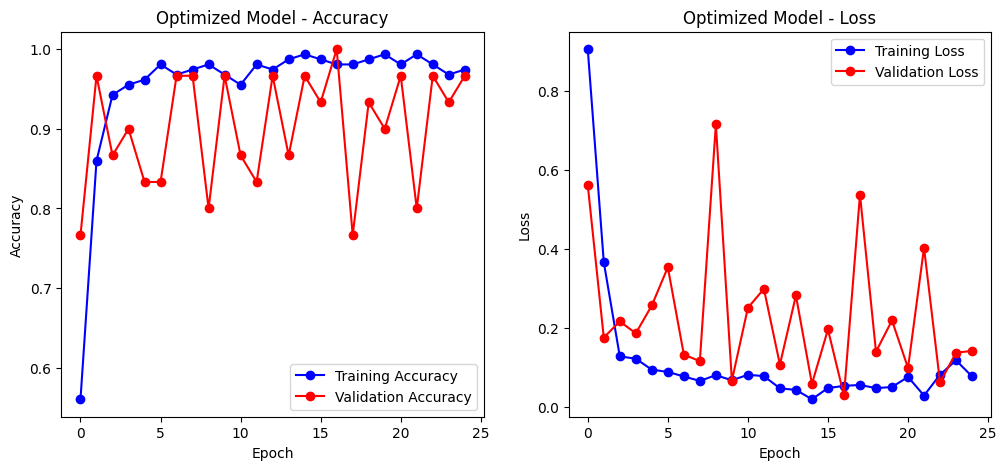

In [13]:
import matplotlib.pyplot as plt

# --- Get the data from the NEW 'history_optimized' object ---
acc = history_optimized.history['accuracy']
val_acc = history_optimized.history['val_accuracy']
loss = history_optimized.history['loss']
val_loss = history_optimized.history['val_loss']

epochs = range(len(acc))

# --- Plot Training & Validation Accuracy ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st plot)

plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Optimized Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)

plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Optimized Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# --- Save the final, trained model ---
# This saves everything into a single file:
# 1. The model's architecture (all the layers)
# 2. The model's trained weights (its "brain")

model_optimized.save('water_classifier_model.h5')

print("Final optimized model has been saved as 'water_classifier_model.h5'")

Final optimized model has been saved as 'water_classifier_model.h5'


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

# --- 1. Load my saved model ---
model = tf.keras.models.load_model('water_classifier_model.h5')
print("Model 'water_classifier_model.h5' loaded successfully.")

# --- 2. Upload a new test image ---
# (When I run this, a button will appear to upload a file)
print("\nPlease upload a single test image (e.g., algae_test.jpg):")
uploaded = files.upload()

# Get the filename of whatever I just uploaded
file_path = list(uploaded.keys())[0]

# --- 3. Load and Pre-process the Image ---
# I must use the same settings as my training data
img = image.load_img(file_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Make it a "batch" of 1
img_array = img_array / 255.0                # Rescale the pixels

# --- 4. Make the Prediction ---
prediction = model.predict(img_array)

# --- 5. Show the Result ---
# My generator's classes were {'algae_bloom': 0, 'healthy_water': 1}
# So, a prediction < 0.5 is 'algae_bloom'
# A prediction > 0.5 is 'healthy_water'

print("\n" + "="*30)
print("--- PREDICTION RESULT ---")
print(f"Image: {file_path}")

if prediction[0][0] > 0.5:
    confidence = prediction[0][0] * 100
    print(f"RESULT: HEALTHY WATER")
    print(f"Confidence: {confidence:.2f}%")
else:
    confidence = (1 - prediction[0][0]) * 100
    print(f"RESULT: ALGAE BLOOM")
    print(f"Confidence: {confidence:.2f}%")
print("="*30)

Model 'water_classifier_model.h5' loaded successfully.

Please upload a single test image (e.g., algae_test.jpg):


Saving 8.jpg to 8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

--- PREDICTION RESULT ---
Image: 8.jpg
RESULT: ALGAE BLOOM
Confidence: 99.69%
